In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Standard library imports
from os.path import join
from collections import OrderedDict
from array import array

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import random

# Type hinting imports
from typing import Callable, Dict, List, Optional, Tuple, Any  # For type annotations

# Google Colab specific imports
from google.colab import drive
drive.mount('/content/drive')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# torchvision imports
import torchvision.transforms as transforms  # For image transformations

# Flower (Federated Learning) imports
import flwr as fl  # Core Flower framework
from flwr.common import (  # Common Flower types and functions
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager  # For managing clients on server-side
from flwr.server.client_proxy import ClientProxy  # For server-side client proxy management

# Device setup
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0


# File path

In [ ]:
input_path = '/content/drive/MyDrive/Colab Notebooks/data'
EMNIST_file_paths = [
    'emnist/emnist-balanced-test.csv',
    'emnist/emnist-balanced-train.csv',
    'emnist/emnist-byclass-test.csv',
    'emnist/emnist-byclass-train.csv',
    'emnist/emnist-bymerge-test.csv',
    'emnist/emnist-bymerge-train.csv',
    'emnist/emnist-digits-test.csv',
    'emnist/emnist-digits-train.csv',
    'emnist/emnist-letters-test.csv',
    'emnist/emnist-letters-train.csv',
    'emnist/emnist-mnist-test.csv',
    'emnist/emnist-mnist-train.csv'
]


EMNIST_digits_test_filepath = join(input_path, EMNIST_file_paths[6])
EMNIST_digits_train_filepath = join(input_path, EMNIST_file_paths[7])

EMNIST_digits_test_filepath, EMNIST_digits_train_filepath

('/content/drive/MyDrive/Colab Notebooks/data/emnist/emnist-digits-test.csv',
 '/content/drive/MyDrive/Colab Notebooks/data/emnist/emnist-digits-train.csv')

# Dataloader

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.int64)

class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.long)
        return x, y

class MnistDataloader(object):
    def __init__(self, training_filepath, testing_filepath, num_of_train, num_of_test):
        self.training_filepath = training_filepath
        self.testing_filepath = testing_filepath
        self.num_of_train = num_of_train
        self.num_of_test = num_of_test
        self.batch_size = 32

        # Load and save the train and test loaders
        (X_train, y_train), (X_test, y_test) = self.load_data()
        # self.train_loader = self.create_data_loader(X_train, y_train)
        self.test_loader = self.create_data_loader(X_test, y_test, shuffle=False)

    def read_images_labels(self, filepath):
        data = pd.read_csv(filepath)
        labels = torch.tensor(data.iloc[:, 0].values, dtype=torch.long)
        images = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float).view(-1, 28, 28)
        return images, labels

    def load_data(self):
        X_train, y_train = self.read_images_labels(self.training_filepath)
        X_test, y_test = self.read_images_labels(self.testing_filepath)

        X_train, X_test = np.expand_dims(np.array(X_train), axis=1), np.expand_dims(np.array(X_test), axis=1)
        y_train, y_test = np.array(y_train), np.array(y_test)

        return (X_train[:self.num_of_train], y_train[:self.num_of_train]), (X_test[:self.num_of_test], y_test[:self.num_of_test])

    def create_data_loader(self, images, labels, shuffle=True):
        dataset = CustomDataset(images, labels)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

# Generate balanced data and unbalanced data

In [ ]:
def split_dataset_balanced(num_clients, X_train, y_train, X_test, y_test, batch_size=32):
    """
    Splits the given training and testing data into balanced subsets for a given number of clients
    and returns lists of DataLoader objects.
    """
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    def create_balanced_subsets(dataset, num_clients):

        # Group indices by label
        label_to_indices = defaultdict(list)
        for idx in range(len(dataset)):
                _, label = dataset[idx]
                label_to_indices[label.item()].append(idx)

        # Find the minimum number of samples for any label
        min_label_count = min(len(indices) for indices in label_to_indices.values())

        # Determine the number of samples per client per label
        samples_per_client_per_label = min_label_count // num_clients

        # Create an array to hold indices for each client
        client_indices = [[] for _ in range(num_clients)]

        # Distribute indices for each label to each client
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)  # Shuffle indices to ensure randomness
            for i in range(num_clients):
                start_idx = i * samples_per_client_per_label
                end_idx = (i + 1) * samples_per_client_per_label
                client_indices[i].extend(indices[start_idx:end_idx])

        # Create subsets for each client
        subsets = [Subset(dataset, indices) for indices in client_indices]

        return subsets

    # Create balanced subsets for train and test datasets
    train_subsets = create_balanced_subsets(train_dataset, num_clients)
    test_subsets = create_balanced_subsets(test_dataset, num_clients)

    # Create DataLoaders for each subset
    train_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in train_subsets]
    test_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=False) for subset in test_subsets]

    return train_loaders, test_loaders




In [ ]:
def create_unbalanced_loaders(train_loaders, test_loaders, label_counts, alpha):
    """
    Converts balanced train and test DataLoader objects into unbalanced DataLoader objects by redistributing the samples.

    """

    def create_unbalanced_loader(loader, p):
        label_to_indices = defaultdict(list)
        dataset = loader.dataset

        # Build the mapping from labels to indices
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            label_to_indices[label.item()].append(idx)

        subset_indices = []
        for label, indices_list in label_to_indices.items():
            prob = p[label]
            for idx in indices_list:
                if np.random.rand() < prob:
                    subset_indices.append(idx)

        subset_dataset = Subset(dataset, subset_indices)
        subset_loader = DataLoader(subset_dataset, batch_size=loader.batch_size, shuffle=True)

        return subset_loader

    unbalanced_train_loaders = []
    unbalanced_test_loaders = []
    for i in range(len(train_loaders)):

        train_loader = train_loaders[i]
        test_loader = test_loaders[i]

        # Generate Dirichlet distribution to get probabilities
        p = np.random.dirichlet([alpha] * label_counts)

        # Normalize probabilities
        p /= np.max(p)

        unbalanced_train_loaders.append(create_unbalanced_loader(train_loader, p))
        unbalanced_test_loaders.append(create_unbalanced_loader(test_loader, p))

    return unbalanced_train_loaders, unbalanced_test_loaders

# Plot label distribution

In [ ]:
def get_labels_from_subset(subset):
    labels = []
    for _, label in subset:
        labels.append(label)
    return labels

def plot_label_distribution(train_loaders):
    client_number = len(train_loaders)
    row = math.ceil(client_number / 5)
    fig, axs = plt.subplots(row, 5, figsize=(10, row * 2))  # Adjusted figsize for better visibility
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    for i, data_loader in enumerate(train_loaders):
        client_dataset = data_loader.dataset
        labels = get_labels_from_subset(client_dataset)
        label_counts = np.bincount(labels)
        # print(label_counts)

        ax = axs[i]
        cmap = plt.cm.YlGnBu  # Choose colormap
        colors = cmap(np.linspace(0.1, 0.9, len(label_counts)))  # Generate colors
        ax.bar(range(len(label_counts)), label_counts, color=colors)
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        ax.set_title(f'Client {i + 1}')

    # Hide any unused subplots
    for j in range(len(train_loaders), len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


Use EMNIST dataset to test

In [ ]:
test_dataloader = MnistDataloader(EMNIST_digits_train_filepath, EMNIST_digits_test_filepath, 60000, 10000)

(X_train, y_train), (X_test, y_test) = test_dataloader.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

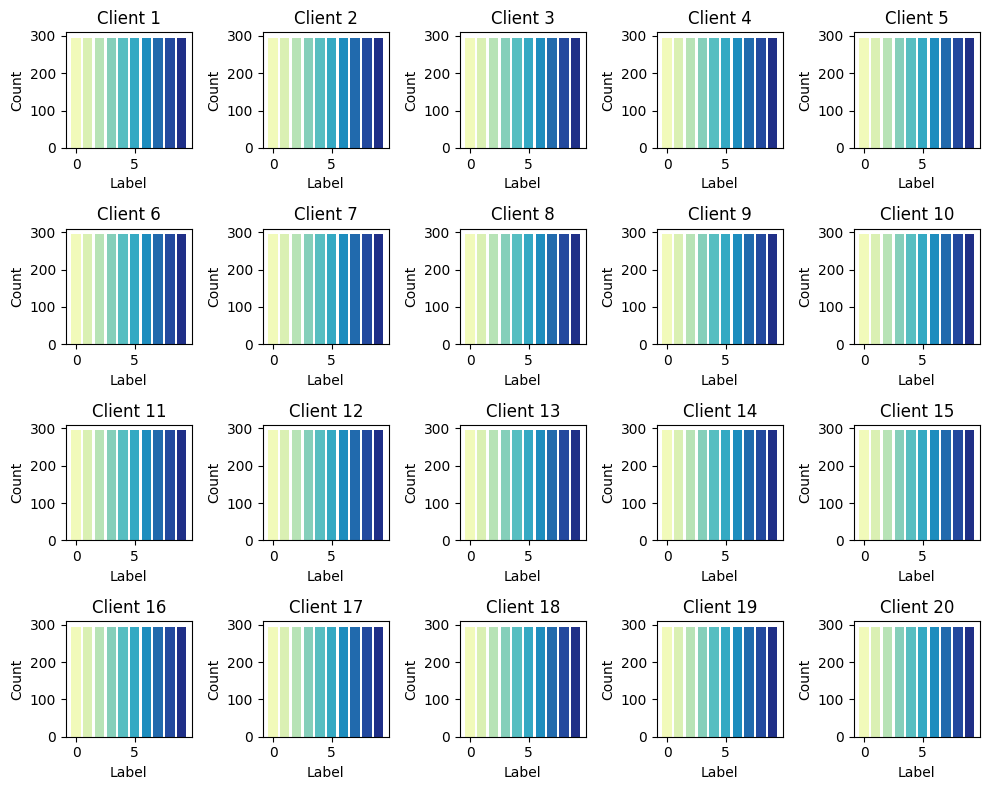

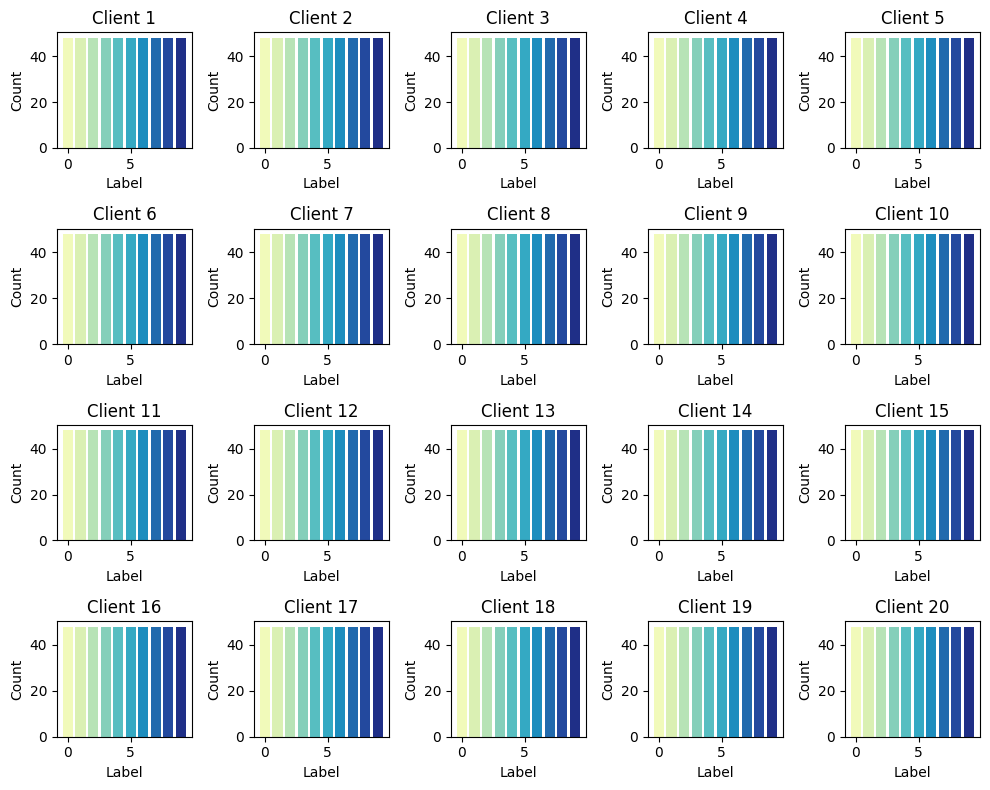

In [ ]:
test_train_balanced_loaders, test_test_balanced_loaders = split_dataset_balanced(20, X_train, y_train, X_test, y_test)

plot_label_distribution(test_train_balanced_loaders)
plot_label_distribution(test_test_balanced_loaders)

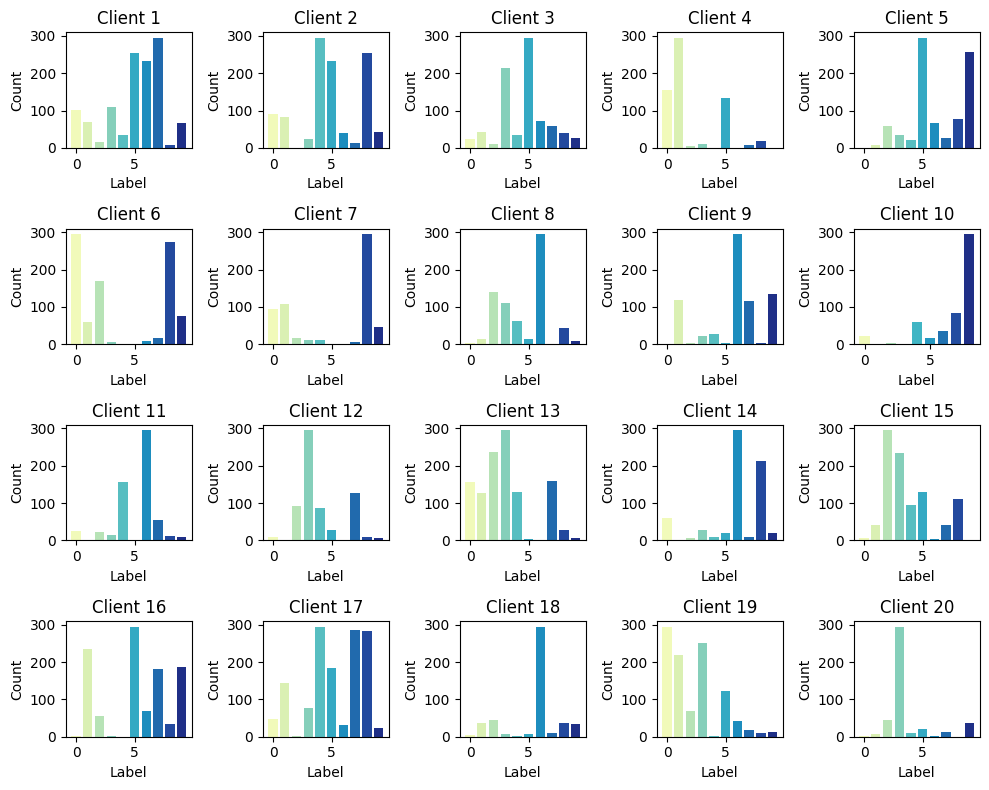

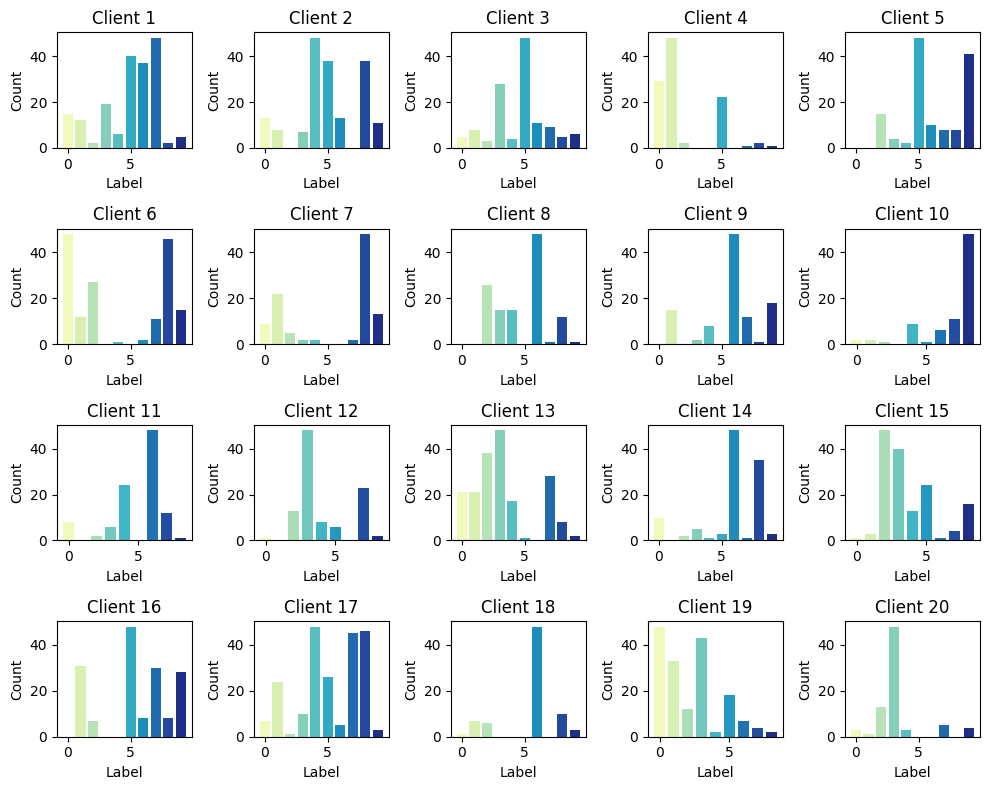

In [ ]:
test_train_unbalanced_loaders, test_test_unbalanced_loaders = create_unbalanced_loaders(test_train_balanced_loaders, test_test_balanced_loaders, 10, 0.5)

plot_label_distribution(test_train_unbalanced_loaders)
plot_label_distribution(test_test_unbalanced_loaders)

# CNN

In [ ]:
def train(net, trainloader, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return loss, accuracy

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)        # 1 input channel (grayscale), 10 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(10, 32, 5)       # 10 input channels, 32 output channels, 5x5 kernel
        self.conv3 = nn.Conv2d(32, 64, 3)       # 32 input channels, 64 output channels, 3x3 kernel
        self.pool  = nn.MaxPool2d(2, 2)         # 2x2 pooling layer
        self.fc1   = nn.Linear(256, 128)        # Dense layer
        self.fc2   = nn.Linear(128, 64)         # Dense layer
        self.fc3   = nn.Linear(64, 10)          # 64 inputs, 10 outputs for the 10 classes
        # Steps:
            # Conv1: 28x28 -> 24x24 (28 - 5 + 1)
            # Pool:  24x24 -> 12x12 (24 / 2)
            # Conv2: 12x12 -> 8x8   (12 - 5 + 1)
            # Pool:  8x8   -> 4x4   (8 / 2)
            # Conv3: 4x4   -> 2x2   (4 - 3 + 1)
            # Flatn: 2x2   -> 1x256 (2 * 2 * 64)
            # Dense: 1x256 -> 1x128
            # Dense: 1x128 -> 1x64
            # Dense: 1x64  -> 1x10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (12, 12, 10)
        x = self.pool(F.relu(self.conv2(x))) # (4, 4, 32)
        x = F.relu(self.conv3(x))            # (2, 2, 64)
        x = x.view(-1, 256)                  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Client

In [ ]:
class Client(fl.client.NumPyClient):
    def __init__(self, net, train_loader, test_loader, num_examples):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.net = net
        self.num_examples = num_examples

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.train_loader, epochs=4)
        _, accuracy = test(self.net, self.test_loader)
        return self.get_parameters(config={}), self.num_examples["trainset"], {"accuracy": accuracy}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.test_loader)
        return float(loss), self.num_examples["testset"], {"accuracy": float(accuracy)}

In [ ]:
def get_client_fn(train_loaders, test_loaders, num_examples):
    """Return a function to construct a client.

    """

    def client_fn(cid: str) -> Client:
        train_loader = train_loaders[int(cid)]
        test_loader = test_loaders[int(cid)]
        net = Net().to(DEVICE)

        # print(f"cid: {int(cid)}")

        return Client(net, train_loader, test_loader, num_examples).to_client()

    return client_fn

# Strategy

## Method A (select all nodes each round)

In [ ]:
class MethodA(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Calculate accuracies for each client, create a dictionary and DataFrame for the round, and compute the mean accuracy
        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}
        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)


        # Update accuracies, losses, and the accuracy DataFrame with the current round's data
        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])


        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def plot_loss_per_client_per_round(self):
        num_rounds = len(self.losses)
        num_clients = len(self.losses[0])

        plt.figure()
        for client_idx in range(num_clients):
            plt.plot(range(1, num_rounds + 1), [self.losses[r][client_idx] for r in range(num_rounds)], marker='o', label=f'Client {client_idx + 1}')

        plt.title("Loss per Client per Round")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)


    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method B (Accuracy-Based Selection Strategy)

In [ ]:
class MethodB(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.accuracies = [None] * num_clients  # Store accuracies for each client
        self.probability_df = pd.DataFrame()

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            selected_clients = client_manager.sample(num_clients=sample_size, min_num_clients=sample_size)

            # store round probabilities
            round_probabilities = {f"Client {cid + 1}": self.p for cid in range(self.num_clients)}

        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            selected_clients = []
            round_probabilities = {}

            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = max(np.exp(-1.5 * last_round_accuracy), 0.1)
                else:
                    prob = self.p

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob:
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        fit_ins = FitIns(parameters, {})

        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Method C (Retain previously calculated selection probability if not selected.)

In [ ]:
class MethodC(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = [] # Store avg accuracies for each round
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        print(f"server_round: {server_round}")

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            selected_clients = client_manager.sample(num_clients=sample_size, min_num_clients=sample_size)

            # store round probabilities
            round_probabilities = {f"Client {cid + 1}": self.p for cid in range(self.num_clients)}

        else:
            print(f"server_round: {server_round}")
            # Round t: Nodes have selection probability based on accuracy from previous round
            selected_clients = []
            round_probabilities = {}

            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = max(np.exp(-1.5 * last_round_accuracy), 0.1)
                else:
                    prob = self.probability_df[client_key].iloc[-1]

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob:
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        fit_ins = FitIns(parameters, {})

        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method D (Retain previously calculated selection probability if not selected.)

# Start Simulation

In [ ]:
# Load model and data
NUM_CLIENTS = 20
ROUND = 50

In [ ]:
def get_evaluate_server_fn(model, test_loader):
    def evaluate_fn(server_round, parameters, config):
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        loss, accuracy = test(model, test_loader)
        return loss, {"accuracy": accuracy}
    return evaluate_fn

## EMNIST

In [ ]:
EMNIST_digits_dataloader = MnistDataloader(EMNIST_digits_train_filepath, EMNIST_digits_test_filepath, 60000, 10000)

(EMNIST_digits_X_train, EMNIST_digits_y_train), (EMNIST_X_test, EMNIST_y_test) = EMNIST_digits_dataloader.load_data()

In [ ]:
EMNIST_digits_X_train.shape, EMNIST_digits_y_train.shape, EMNIST_X_test.shape, EMNIST_y_test.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

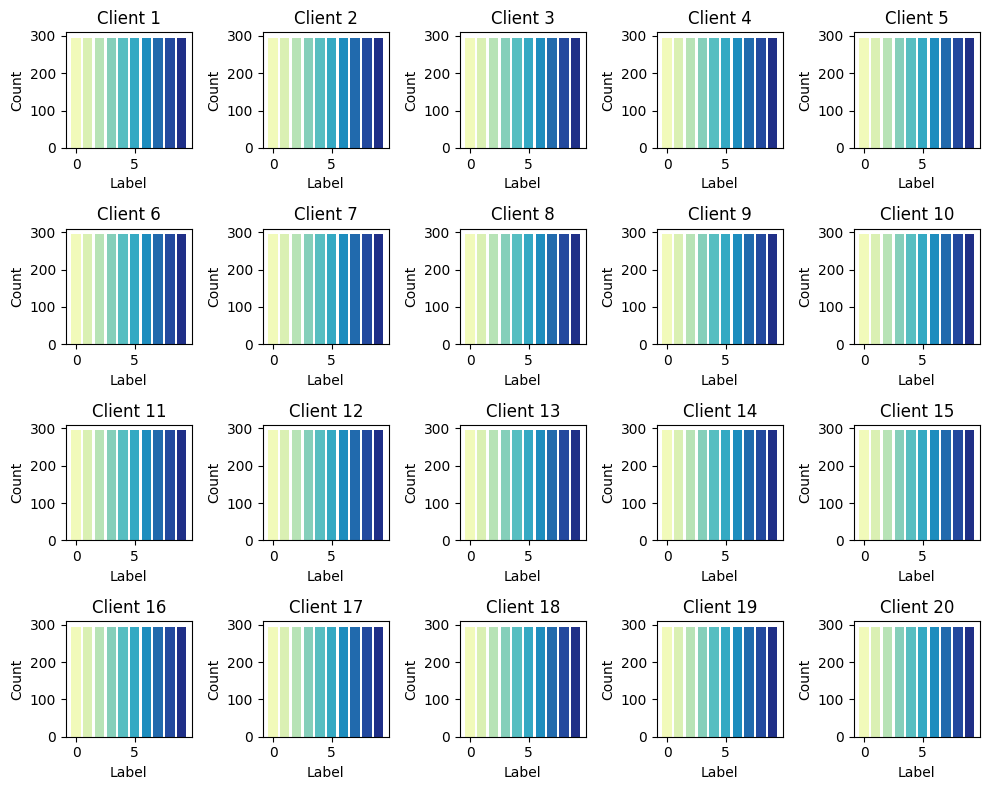

In [ ]:
EMNIST_digits_train_iid_loaders, EMNIST_digits_test_iid_loaders = split_dataset_balanced(NUM_CLIENTS, EMNIST_digits_X_train, EMNIST_digits_y_train, EMNIST_X_test, EMNIST_y_test)

plot_label_distribution(EMNIST_digits_train_iid_loaders)

### EMNIST - Method A - iid data

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 02:12:45,290	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3999123456.0, 'memory': 7998246912.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial paramet

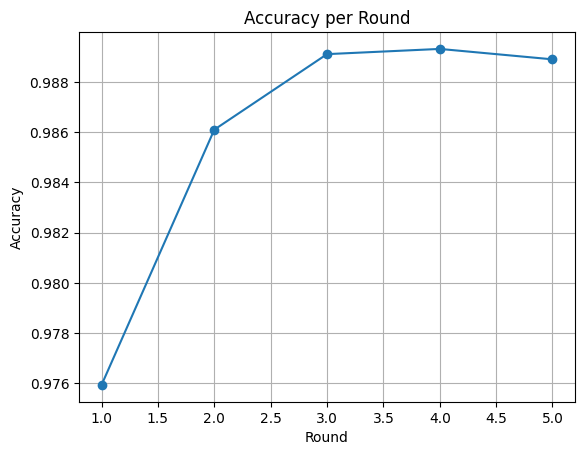

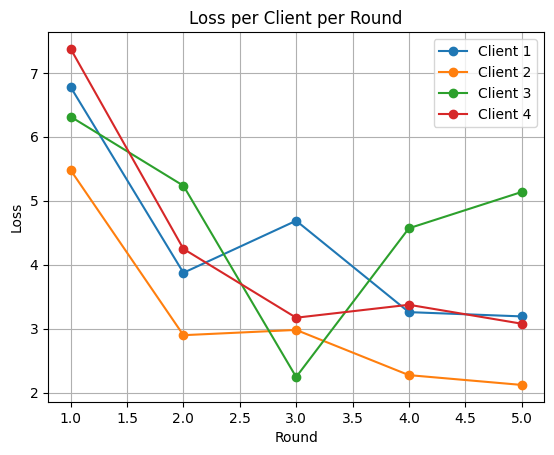

Classification Accuracy Matrix:
   Client 1  Client 2  Client 3  Client 4
1  0.973444  0.978423  0.978423  0.973444
2  0.984232  0.989212  0.984232  0.986722
3  0.984647  0.990041  0.991701  0.990041
4  0.989627  0.992531  0.987552  0.987552
5  0.988382  0.992946  0.984232  0.990041


In [ ]:
EMNIST_digits_iid_strategy_A = MethodA(
        evaluate_fn=get_evaluate_server_fn(Net(), EMNIST_digits_dataloader.test_loader))


train_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_train_iid_loaders)
test_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_test_iid_loaders)
num_examples = {"trainset": train_set_length, "testset": test_set_length}

# Start simulation
fl.simulation.start_simulation(
    client_fn=get_client_fn(EMNIST_digits_train_iid_loaders, EMNIST_digits_test_iid_loaders, num_examples),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND),
    strategy=EMNIST_digits_iid_strategy_A
)


EMNIST_digits_iid_strategy_A.plot_accuracies()
EMNIST_digits_iid_strategy_A.plot_loss_per_client_per_round()
EMNIST_digits_iid_strategy_A.print_accuracy_matrix()
EMNIST_digits_iid_strategy_A.save_accuracy_matrix(f'EMNIST_digits_iid_strategy_A_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### EMNIST - Method A - non iid data

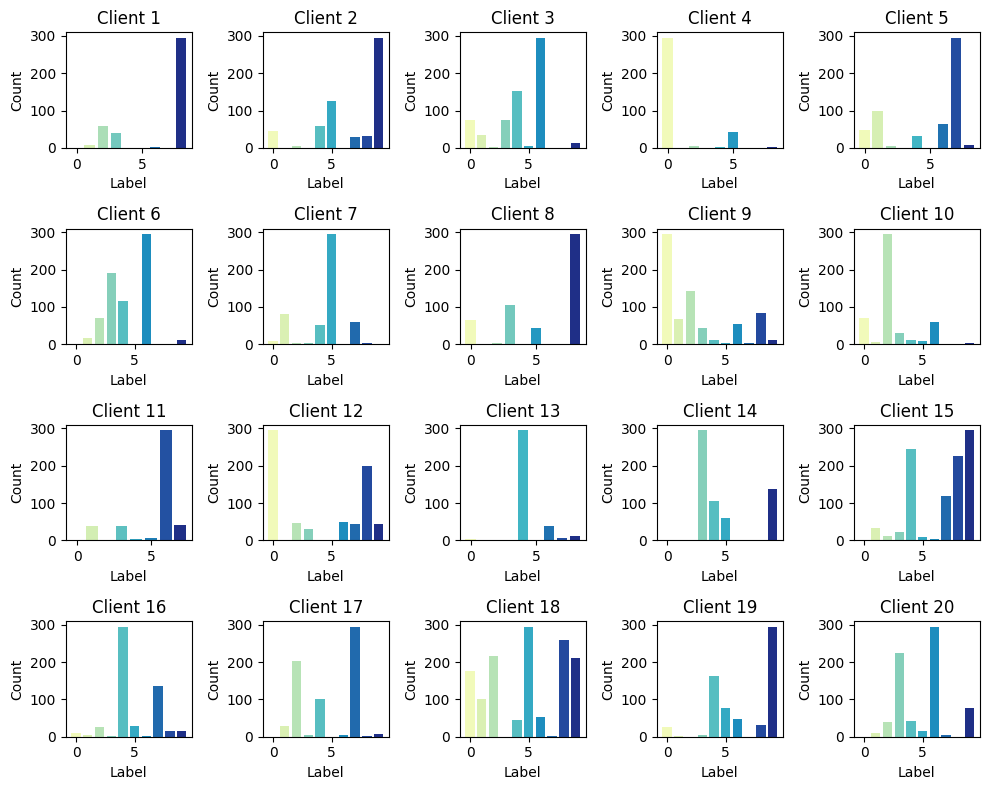

In [ ]:
EMNIST_digits_train_non_iid_loaders, EMNIST_digits_test_non_iid_loaders = create_unbalanced_loaders(EMNIST_digits_train_iid_loaders, EMNIST_digits_test_iid_loaders, 10, alpha=0.3)

plot_label_distribution(EMNIST_digits_train_non_iid_loaders)

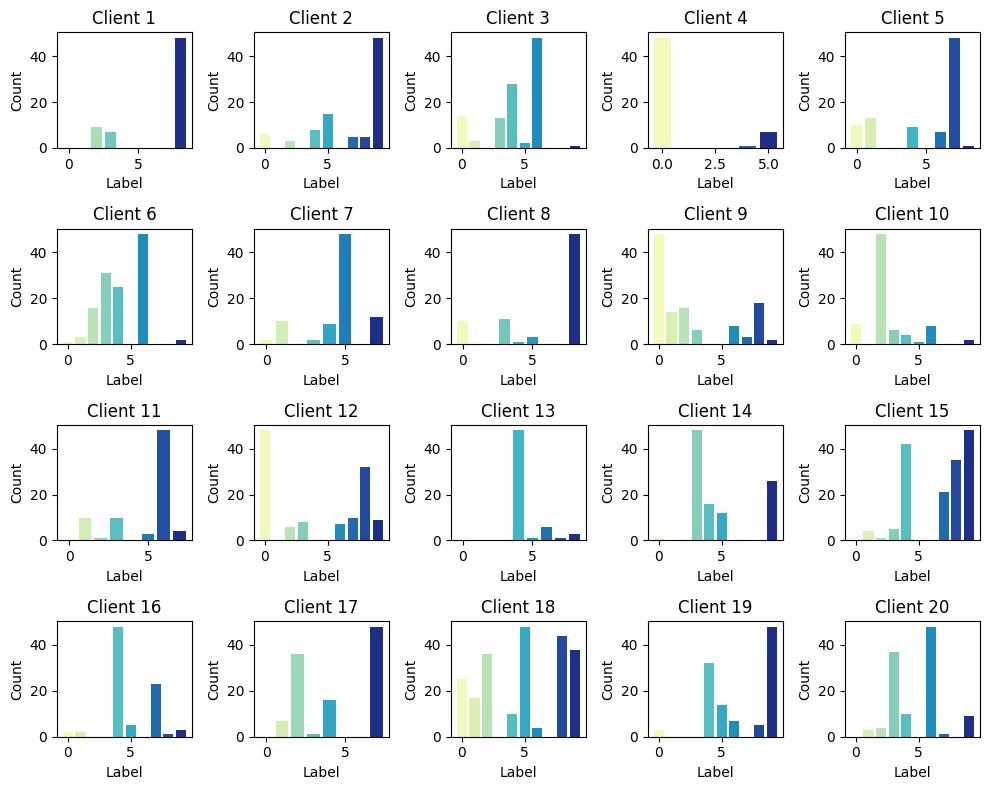

In [ ]:
plot_label_distribution(EMNIST_digits_test_non_iid_loaders)

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-16 06:08:53,174	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 4002259353.0, 'memory': 8004518708.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

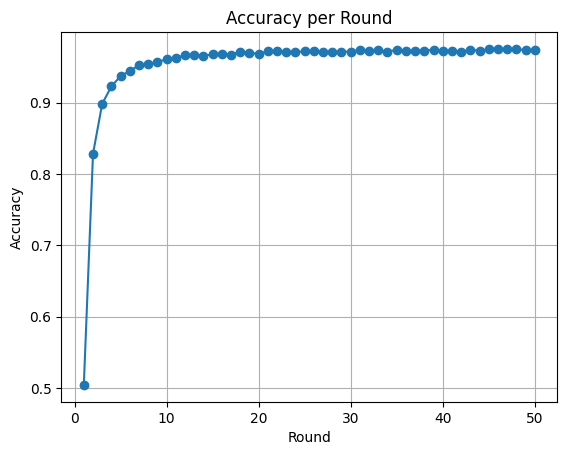

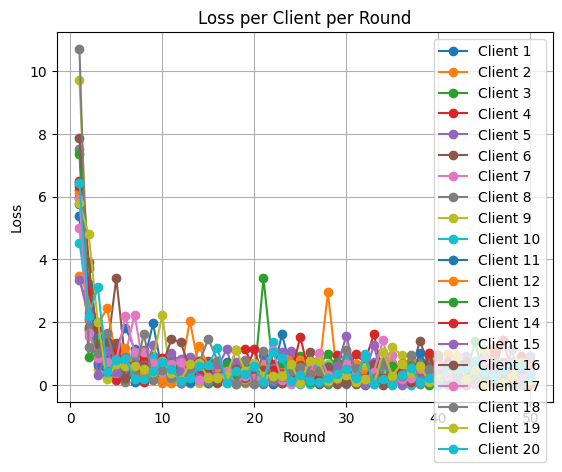

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.655462  0.802198  0.455285  0.632075  0.640845  0.567568  0.410256   
2   0.870370  0.840336  0.947368  0.883333  0.879630  0.675676  0.875000   
3   0.907407  0.898148  0.929577  0.943089  0.950000  0.841121  0.945000   
4   0.915966  0.935185  0.938144  0.923077  0.877551  0.936620  0.871795   
5   0.896226  0.988636  0.944444  0.986842  0.950704  0.880952  0.962264   
6   0.897436  0.915888  0.957983  0.948454  0.918919  0.975000  0.887755   
7   0.957746  0.975610  0.954128  0.953704  0.944444  0.933962  0.892857   
8   0.954955  0.953271  0.962963  0.986842  0.975610  0.923077  0.944954   
9   0.910714  0.988636  0.949153  0.990566  0.897959  0.991870  0.954955   
10  0.966387  0.986842  0.972222  0.972222  0.954128  0.990566  0.949153   
11  0.991870  0.956044  0.963964  0.988636  0.957627  0.958333  0.972222   
12  0.928571  0.972222  0.980000  0.971963  0.957627  1.

In [ ]:
EMNIST_digits_non_iid_strategy_A = MethodA()

train_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_train_non_iid_loaders)
test_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_test_non_iid_loaders)
num_examples = {"trainset": train_set_length, "testset": test_set_length}

# Start simulation
fl.simulation.start_simulation(
    client_fn=get_client_fn(EMNIST_digits_train_non_iid_loaders, EMNIST_digits_test_non_iid_loaders, num_examples),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND),
    strategy=EMNIST_digits_non_iid_strategy_A
)


EMNIST_digits_non_iid_strategy_A.plot_accuracies()
EMNIST_digits_non_iid_strategy_A.plot_loss_per_client_per_round()
# EMNIST_digits_non_iid_strategy_A.print_accuracy_matrix()

In [ ]:

EMNIST_digits_non_iid_strategy_A.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_A_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### EMNIST - Method B - non iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 03:10:24,519	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8007612827.0, 'object_store_memory': 4003806412.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

Serial number of the client selected to fit: ['16', '10', '8', '14', '11', '4', '12', '17', '18', '15']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 463.06254428625107, {'accuracy': 0.428}, 33.6770180679996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['16', '10', '8', '14', '11', '4', '12', '17', '18', '15']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '7', '8', '11', '14', '15', '16', '17']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (2, 130.4651246368885, {'accuracy': 0.8698}, 71.37880217999918)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '7', '8', '11', '14', '15', '16', '17']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '4', '6', '12', '13', '17', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (3, 101.51990779489279, {'accuracy': 0.899}, 103.74053553299927)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '6', '12', '13', '17', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '9', '10', '14', '16', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (4, 76.2655409630388, {'accuracy': 0.9267}, 133.3126757129994)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '9', '10', '14', '16', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '8', '11', '13', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (5, 61.035205045714974, {'accuracy': 0.9399}, 157.71194874499997)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '8', '11', '13', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '6', '10', '12', '13', '16', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (6, 82.34381237626076, {'accuracy': 0.9206}, 185.78947734199937)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '6', '10', '12', '13', '16', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '4', '5', '6', '9', '10', '14', '15', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 47.34350092662498, {'accuracy': 0.9547}, 218.93080672799988)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '4', '5', '6', '9', '10', '14', '15', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['4', '7', '10', '12', '13', '14', '17', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (8, 45.65603193198331, {'accuracy': 0.9562}, 254.9509901879992)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '10', '12', '13', '14', '17', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '5', '6', '8', '11', '13', '15', '16', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 41.961687568807974, {'accuracy': 0.9586}, 288.70413443600046)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '6', '8', '11', '13', '15', '16', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '7', '8', '10', '12', '13', '14', '16', '17']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (10, 40.10832178418059, {'accuracy': 0.9617}, 328.8436563340001)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '7', '8', '10', '12', '13', '14', '16', '17']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '6', '10', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (11, 46.70618982962333, {'accuracy': 0.9564}, 361.2422410859999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '6', '10', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '5', '7', '9', '12', '13', '16', '17', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (12, 35.808671381906606, {'accuracy': 0.9631}, 392.88053204099924)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '7', '9', '12', '13', '16', '17', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '6', '10', '14', '15', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (13, 40.72785463568289, {'accuracy': 0.9615}, 431.73661522600014)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '6', '10', '14', '15', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '5', '6', '7', '9', '16', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (14, 36.95284698379692, {'accuracy': 0.9653}, 459.30521400699945)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '6', '7', '9', '16', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '8', '10', '11', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (15, 32.10943714756286, {'accuracy': 0.9687}, 489.584369528)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '8', '10', '11', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '5', '7', '9', '12', '14', '15', '16']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, 34.10684077918995, {'accuracy': 0.9672}, 528.1449257219992)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '7', '9', '12', '14', '15', '16']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '8', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 38.81161792826606, {'accuracy': 0.9625}, 551.449369091999)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '8', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '5', '7', '9', '11', '13', '15', '17', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (18, 33.307373456133064, {'accuracy': 0.968}, 585.2038549839999)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '5', '7', '9', '11', '13', '15', '17', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '11', '12', '14']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (19, 39.23034015647136, {'accuracy': 0.9635}, 613.2224894659994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '11', '12', '14']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['6', '9', '10', '15', '16', '17', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (20, 34.00491482531652, {'accuracy': 0.9682}, 637.295538499)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '9', '10', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '6', '7', '8', '11', '12', '15', '16', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (21, 30.202560763806105, {'accuracy': 0.9717}, 670.9652523779987)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '6', '7', '8', '11', '12', '15', '16', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '5', '9', '10', '14', '17', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (22, 32.19198724281159, {'accuracy': 0.9693}, 705.848577236)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '9', '10', '14', '17', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '7', '11', '15', '16', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (23, 29.726883389259456, {'accuracy': 0.9718}, 732.155392487999)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '7', '11', '15', '16', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '5', '6', '9', '13', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (24, 30.75203838844027, {'accuracy': 0.9718}, 762.2956486069997)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '6', '9', '13', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['3', '7', '10', '14', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (25, 41.7285371235339, {'accuracy': 0.9596}, 782.9174756259999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '7', '10', '14', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '9', '12', '13', '17', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (26, 29.90460903114581, {'accuracy': 0.9713}, 808.0380407960001)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '9', '12', '13', '17', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '5', '8', '9', '11', '13', '14', '15', '16', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (27, 28.198841162135068, {'accuracy': 0.9737}, 845.992858226)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '8', '9', '11', '13', '14', '15', '16', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '7', '10', '12', '13', '17', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (28, 27.896174338769924, {'accuracy': 0.9735}, 886.1010220999997)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '7', '10', '12', '13', '17', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '4', '8', '9', '10', '12', '14', '16', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (29, 28.681033011627733, {'accuracy': 0.9745}, 924.7037767549991)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '8', '9', '10', '12', '14', '16', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '8', '10', '11', '14', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (30, 31.120340789784677, {'accuracy': 0.9713}, 955.3090009669995)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '8', '10', '11', '14', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 964.68s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.36042785346508
INFO :      		round 2: 1.5063468019167583
INFO :      		round 3: 1.1480592526495457
INFO :      		round 4: 0.7468971417817686
INFO :      		round 5: 0.5096334637297938
INFO :      		round 6: 0.5239251944003627
INFO :      		round 7: 0.4471736188512295
INFO :      		round 8: 0.46398584626149386
INFO :      		round 9: 0.4186331869801506
INFO :      		round 10: 0.4408786482685669
INFO :      		round 11: 0.5379895656660665
INFO :      		round 12: 0.3371784643735737
INFO :      		round 13: 0.4715876099653542
INFO :      		round 14: 0.25607886368379695
INFO :      		round 15: 0.3384427000055439
INFO :      		round 16: 0.19309334077115636
INFO :      		round 17: 0.30863189726369455
INFO :      		round 18: 0.25866907942161727
INFO :      		round 19: 0.282815871550701

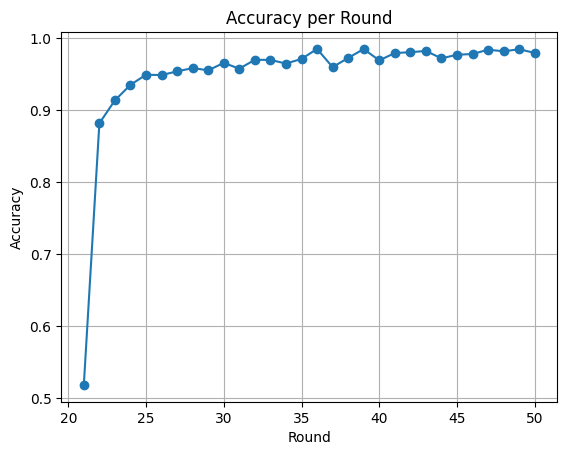

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN       NaN       NaN       NaN  0.386364       NaN       NaN   
2        NaN  0.866667       NaN       NaN  0.386364  0.857143       NaN   
3   0.843750  0.866667  0.963303       NaN  0.886364  0.857143  0.903614   
4   0.843750  0.933333  0.963303  0.910714  0.886364  0.857143  0.903614   
5   0.968750  0.955556  0.963303  0.910714  0.886364  0.857143  0.903614   
6   0.968750  0.955556  0.963303  0.910714  0.931818  0.857143  0.963855   
7   0.906250  0.955556  0.963303  0.946429  0.920455  0.976190  0.951807   
8   0.906250  0.955556  0.963303  0.946429  0.920455  0.976190  0.951807   
9   0.921875  0.955556  0.990826  0.946429  0.920455  0.976190  0.939759   
10  0.921875  0.977778  0.963303  0.982143  0.920455  0.976190  0.939759   
11  0.921875  0.955556  0.963303  0.982143  0.965909  0.960317  0.963855   
12  0.937500  0.955556  0.963303  0.982143  0.965909  0.

In [ ]:
# Load model and data
NUM_CLIENTS = 20
ROUND = 30

EMNIST_digits_non_iid_strategy_B = MethodB(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net(), EMNIST_digits_dataloader.test_loader))


train_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_train_non_iid_loaders)
test_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_test_non_iid_loaders)
num_examples = {"trainset": train_set_length, "testset": test_set_length}

# Start simulation
fl.simulation.start_simulation(
    client_fn=get_client_fn(EMNIST_digits_train_non_iid_loaders, EMNIST_digits_test_non_iid_loaders, num_examples),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND),
    strategy=EMNIST_digits_non_iid_strategy_B
)


EMNIST_digits_non_iid_strategy_B.plot_accuracies()
EMNIST_digits_non_iid_strategy_B.print_accuracy_matrix()
EMNIST_digits_non_iid_strategy_B.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_B_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
EMNIST_digits_non_iid_strategy_B.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_B_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv', index=False)

In [ ]:
EMNIST_digits_non_iid_strategy_B

FedAvg(accept_failures=True)

### EMNIST - Method C - non iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 03:55:55,934	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 8002432206.0, 'object_store_memory': 4001216102.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

server_round: 1
Serial number of the client selected to fit: ['0', '7', '12', '11', '3', '1', '13', '19', '9', '17']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 553.4672901630402, {'accuracy': 0.4268}, 33.182095366000794)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '7', '12', '11', '3', '1', '13', '19', '9', '17']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 2
server_round: 2
Serial number of the client selected to fit: ['2', '5', '8', '13', '14', '15', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (2, 178.09829731285572, {'accuracy': 0.8188}, 65.701381021001)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '8', '13', '14', '15', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 3
server_round: 3
Serial number of the client selected to fit: ['0', '1', '6', '7', '9', '10', '11', '12', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (3, 109.04772996157408, {'accuracy': 0.8902}, 95.85490006200052)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '6', '7', '9', '10', '11', '12', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 4
server_round: 4
Serial number of the client selected to fit: ['2', '3', '4', '7', '8', '9', '10', '12', '16', '17', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (4, 84.14214612543583, {'accuracy': 0.9174}, 135.55584895399988)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '7', '8', '9', '10', '12', '16', '17', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 5
server_round: 5
Serial number of the client selected to fit: ['3', '14', '17']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 98.84607363119721, {'accuracy': 0.9117}, 159.51506017000065)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '14', '17']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 6
server_round: 6
Serial number of the client selected to fit: ['0', '2', '4', '11']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 82.72891349345446, {'accuracy': 0.9181}, 173.6895230580012)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '11']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 7
server_round: 7
Serial number of the client selected to fit: ['0', '2', '3', '13', '14']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 56.61199031025171, {'accuracy': 0.9464}, 194.7718003099999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '13', '14']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 8
server_round: 8
Serial number of the client selected to fit: ['0', '5', '13', '15', '16', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (8, 52.96342857507989, {'accuracy': 0.9514}, 217.54107227900022)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '13', '15', '16', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 9
server_round: 9
Serial number of the client selected to fit: ['4', '6', '10', '13', '15', '16', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (9, 60.0821198807098, {'accuracy': 0.9466}, 241.65633229300147)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '6', '10', '13', '15', '16', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 10
server_round: 10
Serial number of the client selected to fit: ['3', '10', '11', '12', '14', '17', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (10, 47.83668766915798, {'accuracy': 0.9575}, 269.13474590400074)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '10', '11', '12', '14', '17', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 11
server_round: 11
Serial number of the client selected to fit: ['1', '13', '17', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 75.66352549288422, {'accuracy': 0.9346}, 291.50179005500104)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '13', '17', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 12
server_round: 12
Serial number of the client selected to fit: ['3', '6', '16', '18', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (12, 47.52591137087438, {'accuracy': 0.9553}, 310.9802791660004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '6', '16', '18', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 13
server_round: 13
Serial number of the client selected to fit: ['1', '11', '14', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 48.654415555880405, {'accuracy': 0.9584}, 329.9756590730012)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '11', '14', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 14
server_round: 14
Serial number of the client selected to fit: ['0', '1', '6', '10', '15', '17', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (14, 41.5453326262068, {'accuracy': 0.9633}, 352.29805208200014)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '6', '10', '15', '17', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 15
server_round: 15
Serial number of the client selected to fit: ['5', '10', '11', '13']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 61.4581989669241, {'accuracy': 0.9427}, 373.5031554060006)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '10', '11', '13']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 16
server_round: 16
Serial number of the client selected to fit: ['2', '5', '6', '10']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 47.01039455761202, {'accuracy': 0.9586}, 388.7290646390011)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '6', '10']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


server_round: 17
server_round: 17
Serial number of the client selected to fit: ['4', '8']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (17, 54.663211149163544, {'accuracy': 0.9524}, 401.3128778139999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '8']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 18
server_round: 18
Serial number of the client selected to fit: ['3', '9', '13', '14']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 47.93208864075132, {'accuracy': 0.9569}, 415.77231184300035)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '9', '13', '14']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 19
server_round: 19
Serial number of the client selected to fit: ['0', '13', '16', '17']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 38.66559105273336, {'accuracy': 0.9666}, 433.81512508000014)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '13', '16', '17']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 20
server_round: 20
Serial number of the client selected to fit: ['1', '4', '6', '7', '10', '12']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (20, 40.830442038422916, {'accuracy': 0.9663}, 453.14884073100075)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '6', '7', '10', '12']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 21
server_round: 21
Serial number of the client selected to fit: ['2', '6', '9', '11']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 37.943454096559435, {'accuracy': 0.9675}, 472.99574525500066)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '6', '9', '11']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 22
server_round: 22
Serial number of the client selected to fit: ['0', '10', '15']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 41.89445906877518, {'accuracy': 0.9626}, 486.6603044090007)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '10', '15']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


server_round: 23
server_round: 23
Serial number of the client selected to fit: ['4', '10', '12', '13', '16']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (23, 51.27268327190541, {'accuracy': 0.9542}, 502.86622180700033)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '10', '12', '13', '16']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 24
server_round: 24
Serial number of the client selected to fit: ['3', '5', '6']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 46.96225257997867, {'accuracy': 0.9612}, 518.2406708030012)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '6']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 25
server_round: 25
Serial number of the client selected to fit: ['1', '8', '10', '13', '14', '18', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (25, 37.376721663516946, {'accuracy': 0.9675}, 543.1368128070008)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '8', '10', '13', '14', '18', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 26
server_round: 26
Serial number of the client selected to fit: ['0', '2', '6', '7', '13', '15']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (26, 36.01619550882606, {'accuracy': 0.9687}, 567.9303092620012)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '6', '7', '13', '15']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 27
server_round: 27
Serial number of the client selected to fit: ['0', '6', '9']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 41.997175236581825, {'accuracy': 0.9611}, 584.0825107750006)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '6', '9']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 28
server_round: 28
Serial number of the client selected to fit: ['3', '7', '10', '12']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 38.2309682975756, {'accuracy': 0.9671}, 598.4572470540006)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '7', '10', '12']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


server_round: 29
server_round: 29
Serial number of the client selected to fit: ['6', '7', '8', '17']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 38.72994157462381, {'accuracy': 0.9667}, 616.2654573690015)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '7', '8', '17']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


server_round: 30
server_round: 30
Serial number of the client selected to fit: ['5', '7', '9']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (30, 52.78175427590031, {'accuracy': 0.9523}, 633.3360756670008)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '7', '9']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 636.66s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.329756116867065
INFO :      		round 2: 2.1542874920581068
INFO :      		round 3: 0.9268635534163978
INFO :      		round 4: 0.8257630601186644
INFO :      		round 5: 0.5891745376090208
INFO :      		round 6: 0.5708814098034054
INFO :      		round 7: 0.5092043159529567
INFO :      		round 8: 0.6128088769813379
INFO :      		round 9: 0.4903086872239198
INFO :      		round 10: 0.34322772196693613
INFO :      		round 11: 0.5586968929274008
INFO :      		round 12: 0.4942851297557354
INFO :      		round 13: 0.5505599342286587
INFO :      		round 14: 0.40765803387122496
INFO :      		round 15: 0.4186329525145993
INFO :      		round 16: 0.3796716379802092
INFO :      		round 17: 0.390441648196429
INFO :      		round 18: 0.4197116502036806
INFO :      		round 19: 0.4734210519818589
I

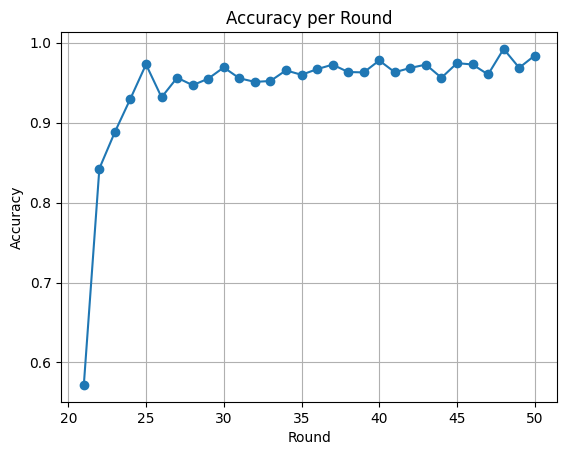

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.593750  0.222222       NaN  0.785714       NaN       NaN       NaN   
2   0.593750  0.222222  0.917431  0.785714       NaN  0.920635       NaN   
3   0.875000  0.766667  0.917431  0.785714       NaN  0.920635  0.831325   
4   0.875000  0.766667  0.954128  0.928571  0.909091  0.920635  0.831325   
5   0.875000  0.766667  0.954128  0.982143  0.909091  0.920635  0.831325   
6   0.906250  0.766667  0.935780  0.982143  0.943182  0.920635  0.831325   
7   0.937500  0.766667  0.935780  0.982143  0.943182  0.920635  0.831325   
8   0.921875  0.766667  0.935780  0.982143  0.943182  0.968254  0.831325   
9   0.921875  0.766667  0.935780  0.982143  0.954545  0.968254  0.951807   
10  0.921875  0.766667  0.935780  0.982143  0.954545  0.968254  0.951807   
11  0.921875  0.977778  0.935780  0.982143  0.954545  0.968254  0.951807   
12  0.921875  0.977778  0.935780  0.946429  0.954545  0.

In [ ]:
# Load model and data
NUM_CLIENTS = 20
ROUND = 30

EMNIST_digits_non_iid_strategy_C = MethodC(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net(), EMNIST_digits_dataloader.test_loader))


train_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_train_non_iid_loaders)
test_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_test_non_iid_loaders)
num_examples = {"trainset": train_set_length, "testset": test_set_length}

# Start simulation
fl.simulation.start_simulation(
    client_fn=get_client_fn(EMNIST_digits_train_non_iid_loaders, EMNIST_digits_test_non_iid_loaders, num_examples),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND),
    strategy=EMNIST_digits_non_iid_strategy_C
)


EMNIST_digits_non_iid_strategy_C.plot_accuracies()
EMNIST_digits_non_iid_strategy_C.print_accuracy_matrix()
EMNIST_digits_non_iid_strategy_C.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_C_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
EMNIST_digits_non_iid_strategy_C.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_C_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv', index=False)

### EMNIST - Method D - non iid data

In [ ]:
class MethodD(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.accuracies = [None] * num_clients  # Store accuracies for each client
        self.probability_df = pd.DataFrame()
        self.availability_df = pd.DataFrame()  # DataFrame to store availability matrix

        self.state = {f"Client {i + 1}": "ON" for i in range(num_clients)}  # state for each clinet (all are 'ON' at the beginning)
        self.p1_dict = {f"Client {i + 1}": np.random.uniform() for i in range(num_clients)}  # Random p1 for each client
        self.p2_dict = {f"Client {i + 1}": np.random.uniform() for i in range(num_clients)}  # Random p2 for each client

        print("Initial p1 values:")
        for client, p1 in self.p1_dict.items():
            print(f"{client}: {p1}")

        print("\nInitial p2 values:")
        for client, p2 in self.p2_dict.items():
            print(f"{client}: {p2}")

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        selected_clients = []
        round_probabilities = {}

        # check transition of availablity
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if self.state[client_key] == "ON":
                if np.random.rand() <= self.p1_dict[client_key]:
                    self.state[client_key] = "OFF"
            elif self.state[client_key] == "OFF":
                if np.random.rand() <= self.p2_dict[client_key]:
                    self.state[client_key] = "ON"

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if np.random.rand() <= self.p and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[str(client_cid)])

                # store round probabilities
                round_probabilities[client_key] = self.p
        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = max(np.exp(-1.5 * last_round_accuracy), 0.1)
                else:
                    prob = self.probability_df[client_key].iloc[-1]

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        # Update availability dataframe
        availability_dict = {}
        for client_key, state in self.state.items():
            availability_dict[client_key] = 1 if state == "ON" else 0

        avail_df = pd.DataFrame(availability_dict, index=[server_round])
        self.availability_df = pd.concat([self.availability_df, avail_df])

        # finish configure_fit
        fit_ins = FitIns(parameters, {})
        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout


Initial p1 values:
Client 1: 0.9023965788785813
Client 2: 0.0715622660734122
Client 3: 0.2332292685236228
Client 4: 0.6386820316735846
Client 5: 0.21807808059691602
Client 6: 0.911416878311904
Client 7: 0.4793834766814079
Client 8: 0.04122920442494249
Client 9: 0.08016649621573757
Client 10: 0.6412004617023334
Client 11: 0.901105865835753
Client 12: 0.25139521355578265
Client 13: 0.3431048121093464
Client 14: 0.22695035062480728
Client 15: 0.5088159985163989
Client 16: 0.7100190097253813
Client 17: 0.9894950444224365
Client 18: 0.162085946702334
Client 19: 0.13592702979664195
Client 20: 0.5017702167505911

Initial p2 values:
Client 1: 0.5054740484183352
Client 2: 0.2904947606461864
Client 3: 0.6647697976925899
Client 4: 0.1785862324185865
Client 5: 0.9388916025165384
Client 6: 0.701611431748321
Client 7: 0.08265091421940418
Client 8: 0.038553968633534996
Client 9: 0.7634575492612232
Client 10: 0.09860646596638623
Client 11: 0.7514901616811314
Client 12: 0.5579420354269052
Client 13: 0.

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 06:18:35,910	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7990129460.0, 'object_store_memory': 3995064729.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=88205) 2024-07-17 06:18:41.141925: E external/l

Serial number of the client selected to fit: ['0', '6', '13', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 623.4166580438614, {'accuracy': 0.3783}, 18.44217056400157)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '6', '13', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '6', '9', '10', '11', '13', '15', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (2, 292.6510857641697, {'accuracy': 0.6899}, 46.076959669000644)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '6', '9', '10', '11', '13', '15', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '11', '12', '13', '17']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 146.61804585158825, {'accuracy': 0.8527}, 74.2339070880007)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '11', '12', '13', '17']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['7', '8', '10', '12', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 132.2138261720538, {'accuracy': 0.864}, 97.81166517400197)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '8', '10', '12', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['5']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (5, 420.8002524971962, {'accuracy': 0.6704}, 109.70176175800225)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['5']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['8', '11', '19']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 115.02555181086063, {'accuracy': 0.8807}, 121.0994973170018)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '11', '19']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['1', '7', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 118.168615616858, {'accuracy': 0.8823}, 133.26136269299968)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '7', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['7', '12', '15', '17', '18']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 68.55238881334662, {'accuracy': 0.9361}, 151.26260517099945)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '12', '15', '17', '18']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['8', '12', '13', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 76.44061888754368, {'accuracy': 0.9285}, 169.28550934800296)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '12', '13', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['3', '6', '7', '8', '10', '13']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 54.8820586388465, {'accuracy': 0.9486}, 189.27965318600036)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '6', '7', '8', '10', '13']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['7']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (11, 485.0380599796772, {'accuracy': 0.6708}, 202.28134065099948)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['7']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '9', '17']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 118.32219778932631, {'accuracy': 0.8826}, 215.29917234000095)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '9', '17']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['13']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (13, 411.52386063337326, {'accuracy': 0.7034}, 227.08954455600178)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['13']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['8']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (14, 105.12136396765709, {'accuracy': 0.8961}, 234.3559552330007)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['8']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['8', '13']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (15, 91.08099339483306, {'accuracy': 0.9138}, 242.27422149999984)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '13']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '8', '11']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 57.50940364878625, {'accuracy': 0.947}, 256.5205522390024)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '8', '11']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['3', '9']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (17, 196.9572158548981, {'accuracy': 0.8449}, 269.0919821669995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '9']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['5', '9', '10', '17', '18']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (18, 61.86375777097419, {'accuracy': 0.9406}, 287.1196439150008)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '9', '10', '17', '18']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['7', '8', '9', '13', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (19, 59.28675661585294, {'accuracy': 0.9443}, 309.5338482389998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '8', '9', '13', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['5']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (20, 174.67794960178435, {'accuracy': 0.8647}, 321.38219239799946)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['5']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 20)


Serial number of the client selected to fit: ['1', '12']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (21, 81.9893406368792, {'accuracy': 0.9236}, 328.0577679550006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '12']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '7', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 49.670540591701865, {'accuracy': 0.9549}, 342.6913652300027)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '7', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['1']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (23, 107.88550642505288, {'accuracy': 0.9062}, 353.48092671500126)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['1']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['0', '17', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 61.38190900487825, {'accuracy': 0.9456}, 363.5523980120015)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '17', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['1', '11', '12']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 43.41315002448391, {'accuracy': 0.9619}, 375.9661601750013)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '11', '12']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['19']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (26, 83.75047667976469, {'accuracy': 0.9175}, 385.7528819780018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['19']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['11', '17', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 51.60130110895261, {'accuracy': 0.9564}, 396.7131613900019)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['11', '17', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['8', '15', '17', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 42.92080071056262, {'accuracy': 0.9646}, 412.9897302019999)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '15', '17', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (29, 45.858941114798654, {'accuracy': 0.9604}, 428.86140095200244)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 1 clients (out of 20)


Serial number of the client selected to fit: ['5']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (30, 218.2563194911927, {'accuracy': 0.8577}, 438.2870116490012)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Serial number of the client selected to evaluate: ['5']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 439.55s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.598092287778854
INFO :      		round 2: 2.4765915063520274
INFO :      		round 3: 1.7061124779284
INFO :      		round 4: 1.290735848248005
INFO :      		round 5: 0.5061399266123772
INFO :      		round 6: 0.5299939389030138
INFO :      		round 7: 0.5270589540402094
INFO :      		round 8: 0.5762333654798567
INFO :      		round 9: 0.4373162453994155
INFO :      		round 10: 0.47343613657479483
INFO :      		round 11: 0.04882255638949573
INFO :      		round 12: 1.1252623625914566
INFO :      		round 13: 0.5631411429494619
INFO :      		round 14: 0.34776125848293304
INFO :      		round 15: 0.7707787388935685
INFO :      		round 16: 0.47237334912642837
INFO :      		round 17: 0.3493722500279546
INFO :      		round 18: 0.46657097795978186
INFO :      		round 19: 0.33690882017835977


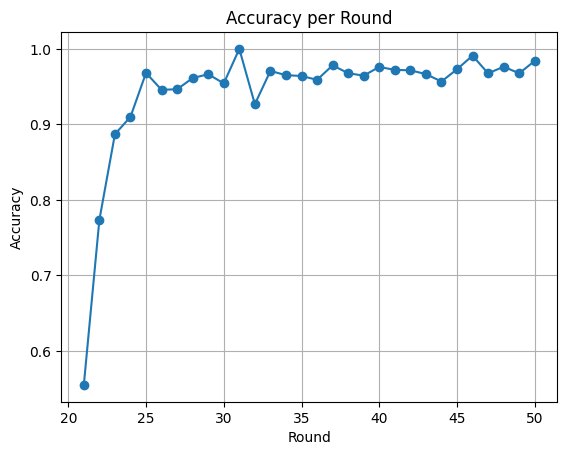

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.859375       NaN       NaN       NaN       NaN       NaN  0.457831   
2   0.859375  0.811111       NaN       NaN       NaN  0.833333  0.746988   
3   0.859375  0.811111  0.926606       NaN  0.920455  0.833333  0.746988   
4   0.859375  0.811111  0.926606       NaN  0.920455  0.833333  0.746988   
5   0.859375  0.811111  0.926606       NaN  0.920455  0.968254  0.746988   
6   0.859375  0.811111  0.926606       NaN  0.920455  0.968254  0.746988   
7   0.859375  0.922222  0.926606       NaN  0.920455  0.968254  0.746988   
8   0.859375  0.922222  0.926606       NaN  0.920455  0.968254  0.746988   
9   0.859375  0.922222  0.926606       NaN  0.920455  0.968254  0.746988   
10  0.859375  0.922222  0.926606  0.982143  0.920455  0.968254  0.915663   
11  0.859375  0.922222  0.926606  0.982143  0.920455  0.968254  0.915663   
12  0.859375  0.911111  0.926606  0.982143  0.920455  0.

In [ ]:
# Load model and data
NUM_CLIENTS = 20
ROUND = 30

EMNIST_digits_non_iid_strategy_D = MethodD(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net(), EMNIST_digits_dataloader.test_loader))


train_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_train_non_iid_loaders)
test_set_length = sum(len(loader.dataset) for loader in EMNIST_digits_test_non_iid_loaders)
num_examples = {"trainset": train_set_length, "testset": test_set_length}

# Start simulation
fl.simulation.start_simulation(
    client_fn=get_client_fn(EMNIST_digits_train_non_iid_loaders, EMNIST_digits_test_non_iid_loaders, num_examples),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND),
    strategy=EMNIST_digits_non_iid_strategy_D
)


EMNIST_digits_non_iid_strategy_D.plot_accuracies()
EMNIST_digits_non_iid_strategy_D.print_accuracy_matrix()
EMNIST_digits_non_iid_strategy_D.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_D_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
EMNIST_digits_non_iid_strategy_D.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_D_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv', index=False)
EMNIST_digits_non_iid_strategy_D.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/EMNIST_digits_non_iid_strategy_D_availability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv', index=False)

In [ ]:
EMNIST_digits_non_iid_strategy_D

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FedAvg(accept_failures=True)